In [6]:
import sys
sys.path.append('../script/')
import os
from os.path import exists
from datetime import datetime
import json
import gc
from functools import partial

import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import log_loss
import optuna

import utils

DEVICE = "cuda"
EPOCHS = 50000
MODELNAME = "LightGBM1017"
if not exists(f"{MODELNAME}/scores"):
    os.makedirs(f"{MODELNAME}/scores")
if not exists(f"{MODELNAME}/weight"):
    os.makedirs(f"{MODELNAME}/weight")
now = datetime.now()
now = str(now)[5:17].replace(" ", "_").replace(":", "")
# writer = SummaryWriter(log_dir=f"{MODELNAME}/tensorboard")

Load and preprocess

In [7]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

def split_data():
    print("Split data")
    path_fold = "../input/folds/train_folds.csv"
    if not exists(path_fold):
        df = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
        df.loc[:, "kfold"] = -1
        df = df.sample(frac=1).reset_index(drop=True)
        targets = df.drop("sig_id", axis=1).values

        mskf = MultilabelStratifiedKFold(n_splits=5)
        for fold_, (tr_, va_) in enumerate(mskf.split(X=df, y=targets)):
            df.loc[va_, "kfold"] = fold_
        df.to_csv(path_fold, index=False)
        print(f"Created: {path_fold}")
    else:
        print("Skipped: already exists")


def preprocess():
    df = pd.read_csv("../input/lish-moa/train_features.csv")
    
    # Label encoding
    mapping = {"cp_type":{"trt_cp": 0, "ctl_vehicle":1},
               "cp_time":{24:0, 48:1, 72:2},
               "cp_dose":{"D1":0, "D2":1}}
    for col in ['cp_type', 'cp_time', 'cp_dose']:
        df[col] = df[col].map(mapping[col])
    
    folds = pd.read_csv("../input/folds/train_folds.csv")

    # Create aux target
    # `nsc_labels` means # of labels found in non-scored train set
    non_scored_df = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
    targets_non_scored = non_scored_df.drop("sig_id", axis=1).to_numpy().sum(axis=1)
    non_scored_df.loc[:, "nsc_labels"] = targets_non_scored
    drop_cols = [c for c in non_scored_df.columns if c not in ("nsc_labels", "sig_id")]
    non_scored_df = non_scored_df.drop(drop_cols, axis=1)
    folds = folds.merge(non_scored_df, on="sig_id", how="left")

    targets = folds.drop(["sig_id", "kfold"], axis=1).columns
    features = df.drop("sig_id", axis=1).columns
    df = df.merge(folds, on="sig_id", how="left")
    
    return df, features, targets

split_data()
df, features, targets = preprocess()

Split data
Skipped: already exists


In [9]:
def run_training(df, fold, params, hp_tune=False):
    save_model = False if hp_tune else True
    print(f'\n[Fold No.{fold:>3}]')
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)

    x_tr = train_df[features].to_numpy()
    x_va = valid_df[features].to_numpy()

    del df
    gc.collect()

    loss_tr, loss_va = [], []
    for i, target in enumerate(targets):
        print(f'Target No.{i:>3} / {len(targets):>3}',end='\r')
        y_tr = train_df[target].to_numpy()
        y_va = valid_df[target].to_numpy()
        dataset_tr = lgb.Dataset(x_tr, label=y_tr)
        dataset_va = lgb.Dataset(x_va, label=y_va, reference=dataset_tr)

        model = lgb.train(params, dataset_tr, EPOCHS, valid_sets=[dataset_tr, dataset_va],
                          verbose_eval=False, early_stopping_rounds=100)

        filename = f"{MODELNAME}/weight/tgt{i}_{now}_fold{fold}.txt"

        preds_tr = model.predict(x_tr, num_iteration=model.best_iteration)
        preds_va = model.predict(x_va, num_iteration=model.best_iteration)

        loss_tr.append(log_loss(y_tr, preds_tr, labels=[0,1]).item())
        loss_va.append(log_loss(y_va, preds_va, labels=[0,1]).item())

        if save_model:
            model.save_model(filename, num_iteration=model.best_iteration)

    with open(f"{MODELNAME}/scores/{now}.txt", "a") as f:
        f.write(f"[fold{fold:>2}] {np.mean(loss_tr):.5}, {np.mean(loss_va):.5}\n")
    print()

print("\nmodel saved at:", filename)


[Fold No.  0]
Target No.206 / 207

model saved at: LightGBM1017/weight/tgt206_10-18_2221_fold0.txt


In [8]:
params = {"metric": 'binary_logloss',
          'objective': 'binary',
          'num_leaves': 491,
          'min_child_weight': 0.03,
          'feature_fraction': 0.3,
          'bagging_fraction': 0.4,
          'min_data_in_leaf': 106,
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "verbose": -1,
          'reg_alpha': 0.4,
          'reg_lambda': 0.6,
          'random_state': 47,
          "force_col_wise": True
         }

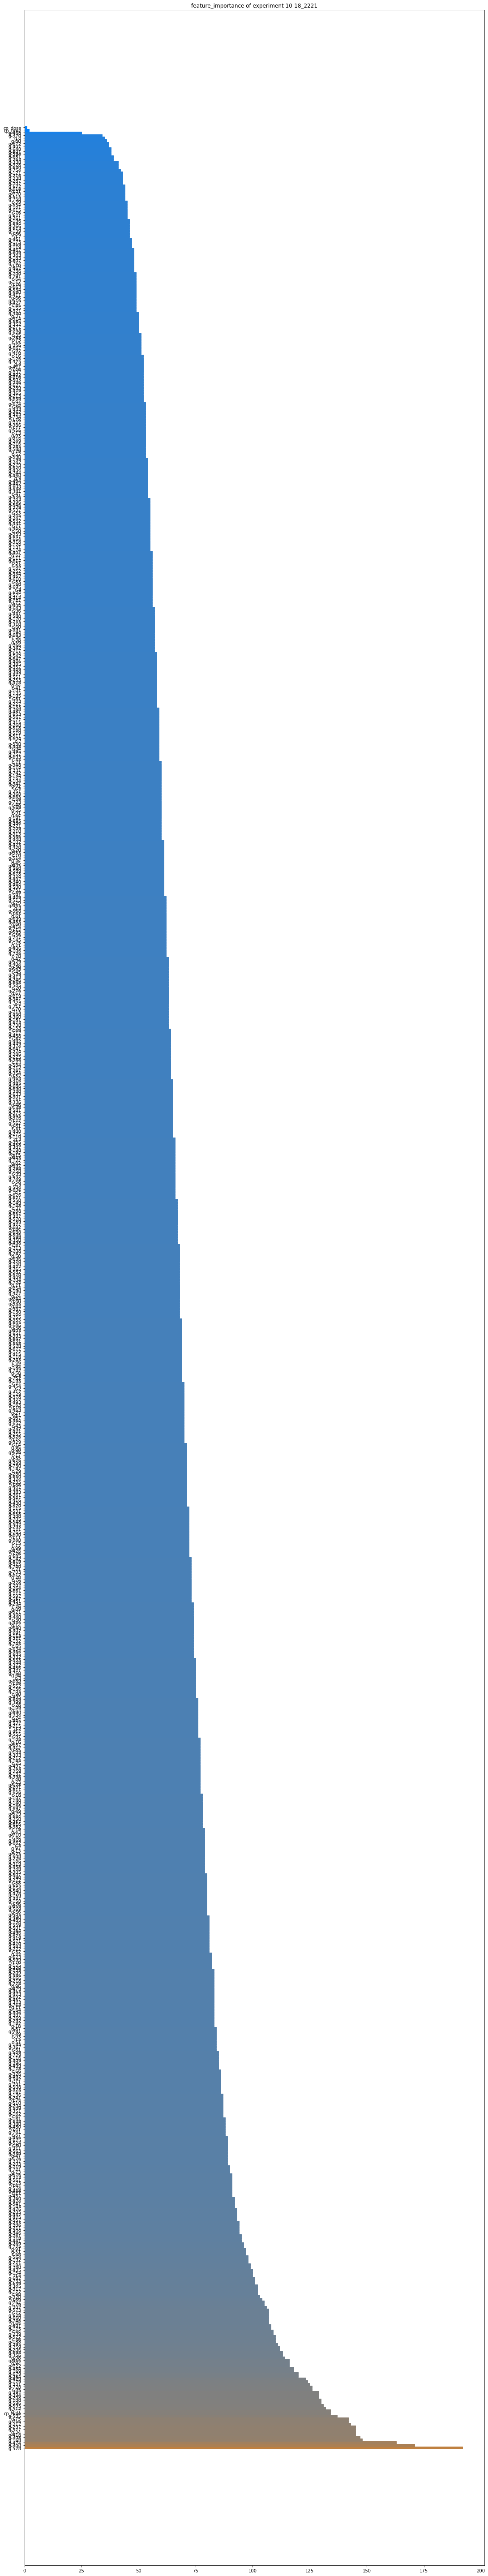

In [68]:
# import matplotlib.pyplot as plt
# importance = pd.DataFrame(model.feature_importance(), index=features, columns=['importance'])
# importance = importance.sort_values(by=['importance'], ascending=False)
# plt.figure(figsize=(15,80))
# plt.title(f'feature_importance of experiment {now}')
# plt.tight_layout()
# barlist = plt.barh(importance['importance'].index, importance['importance'].values, height=.9, edgecolor='white')
# for v, bar in zip(importance['importance'].values, barlist):
#     v_ = np.clip(v / 256, 0, 1)
#     bar.set_color((v_, .5, (1-v_)))
# plt.savefig(f'{MODELNAME}/{now}_importance.png')

In [ ]:
%%time
for fold in range(4):
    run_training(df, fold, params)

In [6]:
with open(f'{MODELNAME}/{now}_params.json', 'w') as f:
    json.dump(params, f, indent=4)

In [7]:
gc.collect()

361

---
Hyper parameter optimization

In [8]:
def objective(trial):
    params = {
        "nn_params": {"dropout": trial.suggest_uniform("dropout", 0.1, 0.8), 
                      "num_layers": trial.suggest_int("num_layers", 1, 7),
                      "hidden_size": trial.suggest_int("hidden_size", 16, 2048),
                      "activation": trial.suggest_categorical("activation", ["relu", "prelu"]),
                      "batchnorm": trial.suggest_categorical("batchnorm", [True, False])},
        "optimizer": trial.suggest_categorical("optimizer", ["SGD", "Adam"]),
        "optim_params": {"lr": trial.suggest_loguniform("lr", 1e-6, 1e-3)},
        "scheduler": "ReduceLROnPlateau",
        "scdl_params": {"threshold": 0.00001},
    }
    loss_all = []
    for fold_ in range(4):
        loss_tmp = run_training(df, fold, params, save_model=False)
        loss_all.append(loss_tmp)
    return np.mean(loss_all)